<a href="https://colab.research.google.com/github/OdinProjectI/BU_CIS535/blob/main/CIS535_CaseStudyProjectDataGenerations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study Project**
    - Name: Rio Atmadja
    - Course: CIS-535
    - Date: 06/26/2023

In [ ]:
%%capture
! pip install pymssql

In [ ]:
import pandas as pd
import numpy as np
import os
import pymssql
import re
import urllib
from bs4 import BeautifulSoup
import datetime

from typing import List, Dict
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

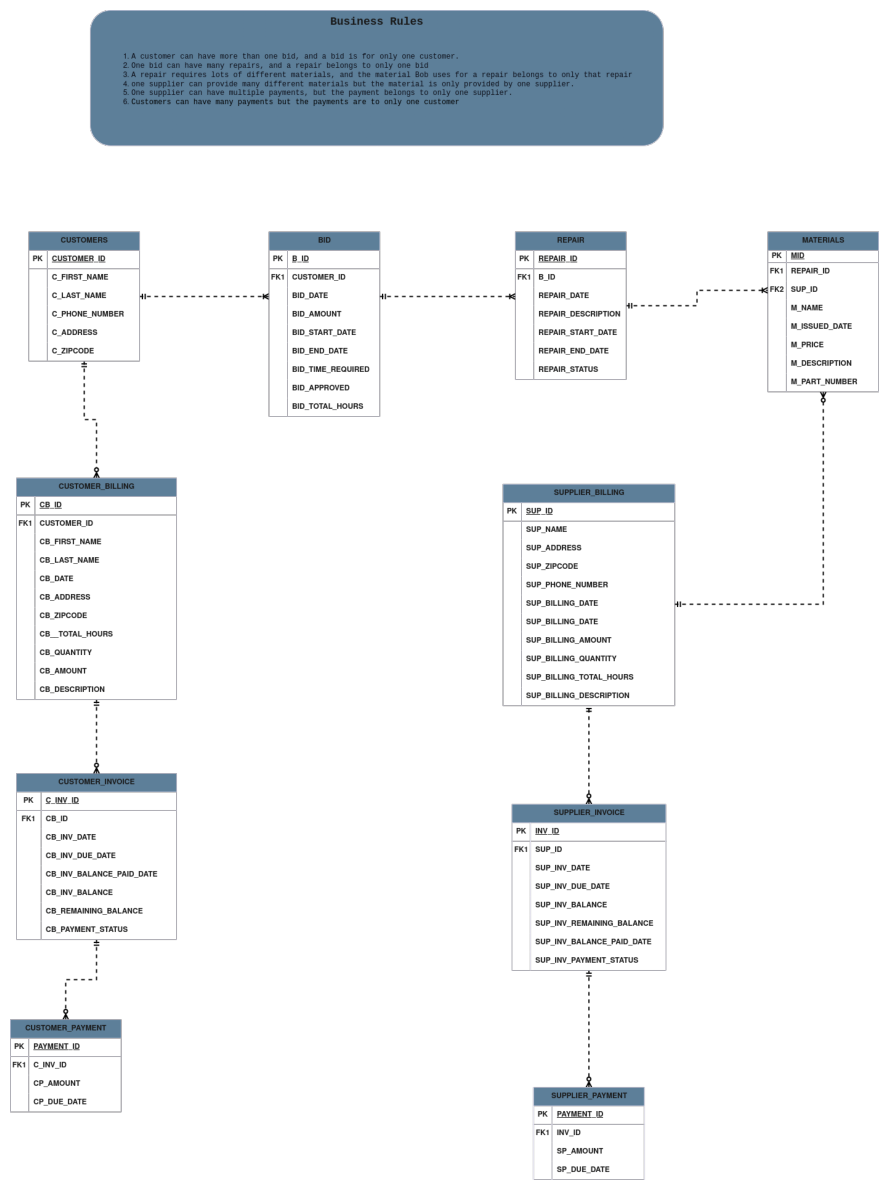

In [ ]:
plt.rcParams['figure.figsize'] = (23,12)
plt.imshow(plt.imread("/content/drive/MyDrive/CIS535_Atmadja_Rio_Week3_CaseStudyProject.drawio.png"))
plt.axis('off')

plt.tight_layout()

# **Create Tables for Bob's Personal Business**

In [ ]:
query: str = """
/*
    Name: Rio Atmadja
    Date: 06/28/2023
    Course: CIS535-T301
    Description: Case Study Case, implement table creations (Week 5)
        - All tables are populated with data. All appropriate primary and foreign keys are added to the tables and match the E-R diagram
*/
USE cis535

CREATE TABLE Customers(
    customer_id INT PRIMARY KEY NOT NULL,
    customer_first_name VARCHAR(255) NOT NULL,
    customer_last_name VARCHAR(255) NOT NULL,
    customer_phone_number VARCHAR(50),
    customer_address VARCHAR(255)
)

CREATE TABLE Bid(
    bid INT PRIMARY KEY NOT NULL,
    bid_date DATETIME,
    bid_amount INT DEFAULT 0,
    bid_start_date DATETIME,
    bid_end_date DATETIME,
    bid_time_required INT DEFAULT 0,
    bid_approved TINYINT DEFAULT 0 ,
    bid_total_hours INT DEFAULT 0,
    customer_id INT NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
)

CREATE TABLE Repair(
    repair_id INT PRIMARY KEY NOT NULL,
    repair_date DATETIME,
    repair_description TEXT,
    repair_start_date DATETIME,
    repair_end_date DATETIME,
    repair_status TINYINT DEFAULT 0,
    bid INT NOT NULL,
    FOREIGN KEY (bid) REFERENCES Bid(bid)
)

CREATE TABLE CustomerBilling(
    customer_billing_id INT PRIMARY KEY NOT NULL,
    customer_billing_first_name VARCHAR(255) NOT NULL,
    customer_billing_last_name VARCHAR(255) NOT NULL,
    customer_billing_date DATETIME,
    customer_billing_address VARCHAR(255) NOT NULL,
    customer_billing_zipcode VARCHAR(50) NOT NULL,
    customer_billing_total_hours INT DEFAULT 0,
    customer_billing_quantity INT DEFAULT 0,
    customer_billing_amount INT DEFAULT 0,
    customer_billing_description TEXT,
    customer_id INT NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
)

CREATE TABLE CustomerInvoice(
    customer_invoice_id INT PRIMARY KEY NOT NULL,
    customer_billing_id INT NOT NULL,
    customer_invoice_date DATE,
    customer_invoice_due_date DATE,
    customer_invoice_balance_paid_state TINYINT DEFAULT 0,
    customer_invoice_balance FLOAT DEFAULT 0.0,
    customer_remaining_balance FLOAT DEFAULT 0.0,
    customer_payment_status TINYINT DEFAULT 0,
    FOREIGN KEY (customer_billing_id) REFERENCES CustomerBilling(customer_billing_id)
)

CREATE TABLE CustomerPayment(
    payment_id INT PRIMARY KEY NOT NULL,
    customer_invoice_id INT NOT NULL,
    customer_payment_amount FLOAT DEFAULT 0.0,
    customer_payment_due_date DATETIME,
    FOREIGN KEY (customer_invoice_id) REFERENCES CustomerInvoice(customer_invoice_id)

)

CREATE TABLE SupplierBilling(
    supplier_id INT PRIMARY KEY NOT NULL,
    supplier_name VARCHAR(255) NOT NULL,
    supplier_address VARCHAR(255) NOT NULL,
    supplier_zipcode VARCHAR(50) NOT NULL,
    supplier_phone_number VARCHAR(50) NOT NULL,
    supplier_billing_date DATETIME,
    supplier_billing_amount FLOAT DEFAULT 0.0,
    supplier_billing_quantity INT DEFAULT 0,
    supplier_biling_total_hours INT DEFAULT 0,
    supplier_billing_description TEXT

)

CREATE TABLE SupplierInvoice(
    invoice_id INT PRIMARY KEY NOT NULL,
    supplier_id INT NOT NULL,
    supplier_invoice_date DATETIME,
    supplier_invoice_due_date DATETIME,
    supplier_invoice_balance DATETIME,
    supplier_invoice_remaining_balance FLOAT DEFAULT 0.0,
    supplier_invoice_balance_paid_date DATETIME,
    supplier_invoice_payment_status TINYINT DEFAULT 0,
    FOREIGN KEY (supplier_id) REFERENCES SupplierBilling(supplier_id)

)

CREATE TABLE SupplierPayment(
    payment_id INT PRIMARY KEY NOT NULL,
    invoice_id INT NOT NULL,
    supllier_amount FLOAT DEFAULT 0.0,
    supplier_due_date DATETIME,
    FOREIGN KEY (invoice_id) REFERENCES SupplierInvoice(invoice_id)

)

CREATE TABLE Materials(
    mid INT PRIMARY KEY NOT NULL,
    repair_id INT NOT NULL,
    supplier_id INT NOT NULL,
    material_name VARCHAR(255),
    material_issued_date DATE,
    material_price FLOAT,
    material_description TEXT,
    material_part_number INT,
    FOREIGN KEY (repair_id) REFERENCES Repair(repair_id),
    FOREIGN KEY (supplier_id) REFERENCES SupplierBilling(supplier_id)
)

"""

with open("/content/drive/MyDrive/Colab Notebooks/CIS535-T301/cis535_atmadja_rio_week7_case_study.sql", 'wt') as f:
    f.write(query)

f.close()

## **Generate Objects Pool**

In [ ]:
url: str = "https://www.sbcmag.info/news/2012/aug/top-50-hardware-retailers"
resp: bytes = urllib.request.urlopen(urllib.request.Request(url=url)).read()
soup = BeautifulSoup(resp)
hardware_stores: List[str] = [ tag.text for tag in soup.find_all("strong") ][1:-1]

materials: List[str] = ["Concrete", "Rebar", "Gravel", "Lumber","Plywood","Nails","Roofing Shingles","Roofing Underlayment","Siding", "Insulation", "Windows", "Doors", "Plumbing Pipes", "Fittings", "Electrical Wires", "Circuit Breakers", "Drywall", "Flooring Materials", "Paint","Trim","Adhesives","Electrical wires","Circuit breakers and panels","Outlets and switches", "Lighting fixtures" ,"Junction boxes"]
lookup_tbl: Dict = {"customer_ids": np.random.choice(range(15000,25100), size=30).tolist(),
                    "bids": np.random.choice(range(150000,250000), size=30).tolist(),
                    "repair_ids": np.random.choice(range(37000,40000), size=30).tolist(),
                    "material_ids": np.random.choice(range(28000,29000), size=30).tolist(),
                    "customer_billing_ids": np.random.choice(range(1000,2000), size=30).tolist(),
                    "supplier_ids": np.random.choice(range(3000,4000), size=30).tolist(),
                    "supplier_inv_ids": np.random.choice(range(5000,6000), size=30).tolist(),
                    "supplier_payments_ids": np.random.choice(range(7000,8000), size=30).tolist(),
                    "customer_billing_ids": np.random.choice(range(8000,9100), size=30).tolist(),
                    "customer_invoice_ids": np.random.choice(range(11000,12000), size=30).tolist(),
                    "customer_payments_ids": np.random.choice(range(12500,12850), size=30).tolist()}

# uniq keys
for k,v in lookup_tbl.items():
    if len(set(v)) != 30:
        lookup_tbl[k] = list(set(lookup_tbl[k] + np.random.choice(range(1000,9000),size= 30 -len(set(v)) ).tolist()))

customers_df: 'DataFrame' = pd.DataFrame( pd.Series(pd.io.html.read_html("https://en.wikipedia.org/wiki/List_of_Pro_Football_Hall_of_Fame_inductees")[1]['Inductee'].apply(lambda row: re.sub("\W|[0-9]{1,}", " ", row ).strip() ).unique()).apply(lambda row: {'customer_first_name': row.split(" ")[0], 'customer_last_name': row.split(" ")[-1] }).to_dict( )).transpose()
billing_custs = customers_df.sample(30)
current_dates: List[str] = pd.Series(pd.date_range(start="2023-01-01", end="2023-12-01", periods=30)).apply(lambda row: (row - pd.tseries.offsets.Day(5)).strftime("%Y-%m-%d")).tolist()
start_dates: List[str] = pd.Series(pd.date_range(start="2023-01-01", end="2023-12-01", periods=30)).apply(lambda row: row.strftime("%Y-%m-%d")).tolist()
end_dates: List[str] = pd.Series(pd.date_range(start="2023-01-01", end="2023-12-01", periods=30)).apply(lambda row: (row + pd.tseries.offsets.Day(14)).strftime("%Y-%m-%d")).tolist()
addresses: List[str] = urllib.request.urlopen(url="https://gist.githubusercontent.com/m4ll0k/11f40f41fac6277dd5a7c57367094873/raw/0bcb298bd75513a398bf353ce7162177350813c9/gistfile1.txt").read().decode('utf-8').split("\n")
zip_codes: List[int] = pd.DataFrame(addresses)[0].apply(lambda row: row.split(" ")[-1] if '-' not in row.split(" ")[-1] else np.nan ).dropna().apply(lambda row: int(row)).unique().tolist()

np.random.shuffle(addresses)

phone_numbers: List = []
for _ in range(1000):
    area_codes: List[int] = np.random.choice(range(1,9),size=3).tolist()
    first_oct: List[int] = np.random.choice(range(0,9),size=3).tolist()
    last_oct: List[int] = np.random.choice(range(0,9),size=4).tolist()


    phone_numbers.append( "(%s)-%s-%s" % ( ''.join(list(map(lambda item: str(item), area_codes))), ''.join(list(map(lambda item: str(item), first_oct))), ''.join(list(map(lambda item: str(item), last_oct)))  ) )

prices: List[int] = np.random.choice(range(200, 15000),size=1000).tolist()
quantity: List[int] = np.random.choice(range(10, 1000),size=1000).tolist()
hours: List[int] = np.random.choice(range(10, 100),size=1000).tolist()
numbers: List[int] = np.random.choice(range(1111, 20000),size=1000).tolist()


# generate billing keywords
keywords_url: str = "https://seattleorganicseo.com/seattle-local-seo-statistics-top-100-search-keywords-seattle-handyman/"
headers: Dict = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/114.0",
                 'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
                 'Accept-Language': "en-US,en;q=0.5",
                 'Accept-Encoding': "gzip, deflate, br",
                 'Alt-Used': "seattleorganicseo.com",
                 'Connection': "keep-alive",
                 'Upgrade-Insecure-Requests': 1,
                 'Sec-Fetch-Dest': 'document',
                 'Sec-Fetch-Mode': 'navigate',
                 'Sec-Fetch-Site': 'cross-site',
                 'DNT': 1,
                 'Sec-GPC': 1,
                 'TE': 'trailers'}

headers.pop('Accept-Encoding')

billing_descp_keywords: bytes = urllib.request.urlopen(urllib.request.Request(url=keywords_url, headers=headers)).read()
billing_soup: 'BeautifulSoup' = BeautifulSoup(billing_descp_keywords)
billing_descriptions: List[str] = [ tag.text.title() for tag in billing_soup.find_all("td") if tag.get('align') == 'LEFT' and tag.get('height') == None and re.findall(r"[a-z]{1,}", tag.text) ][1:]


# **Populate Tables (Week 7 Assignment)**

In [ ]:
con: 'MSSQL' = pymssql.connect(user=os.environ['USER'],
                               password=os.environ['PASSWD'],
                               server=os.environ['SERVER'],
                               database='cis535')
cursor = con.cursor()
cursor.execute(query)
con.commit()

In [ ]:
bob_customers_df[bob_customers_df.apply(lambda row: 'NY' in row['customer_address'], axis=1) ].head(3)

,customer_id,customer_fist_name,customer_last_name,customer_phone_number,customer_address
1,21257,Ozzie,Carson,(543)-726-1412,"5033 Transit Road, Clarence NY 14031"
3,18325,Mac,Nagurski,(538)-754-5848,"3133 E Main St, Mohegan Lake NY 10547"
12,22344,Franco,Schramm,(661)-627-0687,"13858 Rt 31 W, Albion NY 14411"


In [ ]:
 material_df: 'DataFrame' = pd.DataFrame({'mid':lookup_tbl.get('material_ids'),
                                        'repair_id': lookup_tbl.get('repair_ids') ,
                                        'supplier_id': lookup_tbl.get('supplier_ids'),
                                          'material_name': np.random.choice(materials, size=30).tolist(),
                                          'material_issued_date': np.random.choice(current_dates, size=30).tolist(),
                                          'material_price': np.random.choice(prices, size=30).tolist(),
                                          'material_description': pd.Series(np.random.choice(materials,size=30)).apply(lambda row: 'Fix/Upgrade %s' % (row)).tolist(),
                                          'material_part_number': np.random.choice(numbers, size=30).tolist()
                                        })


bob_customers_df: 'DataFrame' = pd.DataFrame({'customer_id': lookup_tbl.get('customer_ids'),
                                                'customer_fist_name': customers_df['customer_first_name'].sample(30).tolist(),
                                                'customer_last_name': customers_df['customer_last_name'].sample(30).tolist(),
                                                'customer_phone_number': np.random.choice(phone_numbers, size=30).tolist(),
                                                'customer_address': np.random.choice(addresses, size=30).tolist()
                                                })


supplier_billing_df: 'DataFrame' = pd.DataFrame({'supplier_id': lookup_tbl.get('supplier_ids'),
                                                'supplier_name': np.random.choice(hardware_stores, size=30).tolist(),
                                                'supplier_address': np.random.choice(addresses, size=30).tolist(),
                                                'supplier_zipcode': np.random.choice(zip_codes, size=30).tolist(),
                                                'supplier_phone_number': np.random.choice(phone_numbers, size=30).tolist(),
                                                'supplier_billing_date': np.random.choice(current_dates, size=30).tolist(),
                                                'supplier_billing_amount': np.random.choice(prices, size=30).tolist(),
                                                'supplier_billing_quantity': np.random.choice(quantity, size=30).tolist(),
                                                'supplier_biling_total_hours': np.random.choice(hours, size=30).tolist(),
                                                'supplier_billing_description': np.random.choice(billing_descriptions, size=30).tolist() })

supplier_payments_df: 'DataFrame' = pd.DataFrame({'payment_id': np.random.choice(range(1000,2000), size=30).tolist(),
                                                  'invoice_id': lookup_tbl.get('supplier_inv_ids'),
                                                  'supplier_amount': np.random.choice(prices, size=30).tolist(),
                                                  'supplier_due_date': np.random.choice(current_dates, size=30).tolist()
                                                  })

supplier_invoice: 'DataFrame' = pd.DataFrame({'invoice_id': lookup_tbl.get('supplier_inv_ids'),
                                              'supplier_id': lookup_tbl.get('supplier_ids'),
                                              'supplier_invoice_date': np.random.choice(start_dates, size=30).tolist(),
                                              'supplier_invoice_due_date':np.random.choice(end_dates, size=30).tolist(),
                                              'supplier_invoice_balance': np.random.choice(prices, size=30).tolist(),
                                              'supplier_invoice_remaining_balance': np.random.choice(prices, size=30).tolist(),
                                              'supplier_invoice_balance_paid_date': np.random.choice(current_dates, size=30).tolist(),
                                              'supplier_invoice_payment_status': np.random.choice(range(2), size=30).tolist()
                                              })

customer_payment: 'DataFrame' = pd.DataFrame({'payment_id': np.random.choice(range(1000,2000), size=30).tolist(),
                                              'customer_invoice_id': lookup_tbl.get('customer_invoice_ids'),
                                              'customer_payment_amount': np.random.choice(prices, size=30).tolist(),
                                              'customer_payment_due_date': np.random.choice(current_dates, size=30).tolist()
                                              })

customer_billings: 'DataFrame' = pd.DataFrame({'customer_billing_id': lookup_tbl.get('customer_billing_ids'),
                                               'customer_billing_first_name': billing_custs['customer_first_name'].tolist() ,
                                               'customer_billing_last_name': billing_custs['customer_last_name'].tolist(),
                                               'customer_billing_date': np.random.choice(current_dates,size=30),
                                               'customer_billing_address': np.random.choice(addresses,size=30),
                                               'customer_billing_zipcode': np.random.choice(zip_codes,size=30),
                                               'customer_billing_total_hours': np.random.choice(hours,size=30) ,
                                               'customer_billing_quantity': np.random.choice(quantity,size=30),
                                               'customer_billing_amount': np.random.choice(prices,size=30),
                                               'customer_billing_description': np.random.choice(billing_descriptions, size=30).tolist(),
                                               'customer_id': lookup_tbl.get('customer_ids')

                                               })

bid: 'DataFrame' = pd.DataFrame({'bid': lookup_tbl.get('bids'),
                                 'bid_date': np.random.choice(current_dates, size=30).tolist(),
                                 'bid_amount': np.random.choice(prices, size=30).tolist() ,
                                 'bid_start_date': np.random.choice(start_dates, size=30).tolist() ,
                                 'bid_end_date': np.random.choice(end_dates, size=30).tolist() ,
                                 'bid_time_required': np.random.choice(hours, size=30).tolist() ,
                                 'bid_approved': np.random.choice(range(2), size=30).tolist() ,
                                 'bid_total_hours':  np.random.choice( np.array(hours) * 5 , size=30).tolist() ,
                                 'customer_id': lookup_tbl.get('customer_ids') ,
                                 })

repair: 'DataFrame' = pd.DataFrame({'repair_id': lookup_tbl.get('repair_ids'),
                                    'repair_date': np.random.choice(current_dates, size=30).tolist(),
                                    'repair_description': np.random.choice(billing_descriptions, size=30).tolist(),
                                    'repair_start_date': np.random.choice(start_dates, size=30).tolist(),
                                    'repair_end_date': np.random.choice(end_dates, size=30).tolist(),
                                    'repair_status': np.random.choice(range(2), size=30).tolist(),
                                    'bid': lookup_tbl.get('bids')
                                    })

balance: 'np.array' =  np.array(prices)
customer_invoice: 'DataFrame' = pd.DataFrame({'customer_invoice_id': lookup_tbl.get('customer_invoice_ids') ,
                                              'customer_billing_id': lookup_tbl.get('customer_billing_ids'),
                                              'customer_invoice_date': np.random.choice(current_dates, size=30).tolist(),
                                              'customer_invoice_due_date': np.random.choice(start_dates, size=30).tolist() ,
                                              'customer_invoice_balance_paid_state': np.random.choice(range(2), size=30).tolist() ,
                                              'customer_invoice_balance': np.random.choice(prices, size=30).tolist(),
                                              'customer_remaining_balance': np.random.choice( balance * 0.7, size=30).tolist(),
                                              'customer_payment_status': np.random.choice(range(2), size=30).tolist()

                                              })

## **Generate Bob Customer's Table**

In [ ]:
cursor.executemany("INSERT INTO Customers(%s) VALUES(%s)" % (  ','.join(pd.read_sql("SELECT * FROM Customers", con=con).columns.tolist()) ,','.join(["%s"] * bob_customers_df.shape[1]) ),  bob_customers_df.apply(lambda row: tuple(row.tolist()) ,axis=1 ).tolist() )
con.commit()

## **Populate Bid Table**

In [ ]:
cursor.executemany("INSERT INTO Bid(bid,bid_date,bid_amount,bid_start_date,bid_end_date,bid_time_required,bid_approved,bid_total_hours,customer_id) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)", bid.apply(lambda row: tuple(row.tolist()), axis=1).tolist())
con.commit()

## **Populate Repair Table**

In [ ]:
cursor.executemany("INSERT INTO Repair(repair_id,repair_date,repair_description,repair_start_date,repair_end_date,repair_status,bid) VALUES(%s,%s,%s,%s,%s,%s,%s)", repair.apply(lambda row: tuple(row), axis=1).tolist() )
con.commit()

# **Populate Supplier Billings**

In [ ]:
args_sb: str = "INSERT INTO SupplierBilling(%s) VALUES(%s)" % (",".join(pd.read_sql("SELECT * FROM SupplierBilling", con=con).columns.tolist()), ','.join(["%s"] * supplier_billing_df.shape[1]) )
cursor.executemany(args_sb, supplier_billing_df.apply(lambda row: tuple(row.tolist()) , axis=1).tolist() )
con.commit()

## **Populate Materials Table**

In [ ]:
materials_args: str = cursor.executemany("INSERT INTO Materials(mid,repair_id,supplier_id,material_name,material_issued_date,material_price,material_description,material_part_number) VALUES(%s,%s,%s,%s,%s,%s,%s,%s)", material_df.apply(lambda row: tuple(row.tolist()), axis=1).tolist() )
con.commit()

## **Populate Supplier Invoice**

In [ ]:
sup_inv_args: str = "INSERT INTO SupplierInvoice(%s) VALUES(%s)" % (','.join(pd.read_sql("SELECT * FROM SupplierInvoice", con=con).columns.tolist()), ','.join(['%s'] * supplier_invoice.shape[1]))
cursor.executemany(sup_inv_args, supplier_invoice.apply(lambda row: tuple(row.tolist()), axis=1).tolist()  )
con.commit()

## **Populate Supplier Payment**
    - TODO: Check the payment_id before insert

In [ ]:
cols: List[str] = pd.read_sql("SELECT * FROM SupplierPayment", con=con).columns.tolist()
supplier_payments_args: str = "INSERT INTO SupplierPayment(%s) VALUES(%s)" % (','.join(cols), ','.join(["%s"] * len(cols)))
cursor.executemany(supplier_payments_args, supplier_payments_df.apply(lambda row: tuple(row.tolist()), axis=1).tolist() )
con.commit()

## **Customer Billing**

In [ ]:
cols: List[str] = pd.read_sql("SELECT * FROM CustomerBilling", con=con).columns.tolist()
args: str = "INSERT INTO CustomerBilling(%s) VALUES(%s)" % (','.join(cols), ','.join(['%s'] * len(cols)))
cursor.executemany(args, customer_billings.apply(lambda row: tuple(row.tolist()), axis=1).tolist() )

## **Customer Invoice**

In [ ]:
cols: List[str] = pd.read_sql("SELECT * FROM CustomerInvoice", con=con).columns.tolist()
args: str=  "INSERT INTO CustomerInvoice(%s) VALUES(%s)" % ( ','.join(cols), ','.join(['%s'] * len(cols)) )
cursor.executemany(args, customer_invoice.apply(lambda row: tuple(row.tolist()) ,axis=1).tolist() )

## **Customer Payment**

In [ ]:
customer_payment['customer_invoice_id'] = pd.read_sql("SELECT DISTINCT customer_invoice_id FROM CustomerInvoice", con=con)['customer_invoice_id'].tolist()
cols: List[str] = pd.read_sql("SELECT * FROM CustomerPayment", con=con).columns.tolist()
args: str = "INSERT INTO CustomerPayment(%s) VALUES(%s)" % (','.join(cols), ','.join(['%s'] * len(cols)) )

cursor.executemany(args, customer_payment.apply(lambda row: tuple(row.tolist()), axis=1).tolist() )
con.commit()

# **Generate Insert Statements**

In [ ]:
insert_query: str = ""

for tbl in [ re.sub('CREATE TABLE |\(', '',item).strip() for item in query.split("\n") if 'CREATE' in item ]:
    df: 'DataFrame' = pd.read_sql(f"SELECT * FROM {tbl}" , con=con)
    for row in df.apply(lambda row: "INSERT INTO %s(%s) VALUES(%s)" % ( tbl, ','.join( df.columns.tolist()), ','.join([ "'%s'" % (col) if isinstance(col, str) else "'%s'" % (col.strftime("%Y-%m-%d")) if isinstance(col, pd._libs.tslibs.timestamps.Timestamp) or isinstance(col, datetime.date) else str(col) for col in row.tolist() ] ) ) ,axis=1 ).tolist():
        insert_query += "%s\n" % (row)


with open("/content/drive/MyDrive/Colab Notebooks/CIS535-T301/cis535_case_study_populate_tbls.sql", "wt") as f:
    f.write(insert_query)

f.close()



# **SQL Queries: Bob's Personal Business Report (Week 9)**
    - Queries:

    1. List the names of the customers who provided bids last month.
    2. List all the customers that have an outstanding balance (amount due to Bob) that is greater than $500.
    3. List all the suppliers where Bob has an outstanding balance that is greater than $1,000.
    4. List all the material that was used for bids where the estimated hours for the bid was greater than 40 hours.
    5. List all the material that Bob purchased from a specific supplier (Note: you can decide on the supplier but there should only be one supplier).

## **Business Transactions**

In [ ]:
business_transactions: str = """
/*
    Description: Monthly report
*/

WITH business_months(curr_month) AS (
    -- generate dummy business operations months
    SELECT 1
    UNION ALL
    SELECT curr_month + 1 FROM business_months WHERE curr_month < 12
),

dummy_months AS
(SELECT
    b.curr_month,
    DATENAME(month, DATEFROMPARTS(2023, b.curr_month, 01)) AS "month_name"

FROM business_months b),

business_transactions AS (

    SELECT
        b.bid_date,
        b.bid_amount,
        b.bid_time_required,
        CASE
            WHEN b.bid_approved = 1 THEN 'Approved'
            ELSE 'Not Approved'
        END AS "bid_status",
        CASE
            WHEN b.bid_approved = 1 THEN 1
            ELSE 0
        END AS "n_bid_approved",
        r.repair_date,
        m.material_name,
        m.material_description,
        SUM(m.material_price) OVER(PARTITION BY b.bid) AS "material_costs", -- total material cost for the current project
        FORMAT(b.bid_date, 'yyyy-MM') AS "transc_date"

    FROM BID b
    JOIN Repair r ON r.bid = b.bid
    JOIN Materials m ON m.repair_id = r.repair_id ),

monthly_jobs_transc AS
(SELECT
    DISTINCT bs.transc_date,
    bs.bid_date,
    bs.bid_amount,
    SUM(bs.bid_amount) OVER(PARTITION BY bs.transc_date) AS "total_bid_amount",
    bs.bid_time_required,
    bs.bid_status,
    SUM( bs.material_costs ) OVER(PARTITION BY bs.transc_date) AS "material_total_cost",
    bs.n_bid_approved,
    bs.material_name

FROM business_transactions bs),

monthly_reports AS
(SELECT
    dm.month_name,
    SUM( CAST( ISNULL(mjs.bid_amount, 0.0) AS MONEY ) ) OVER(PARTITION BY dm.month_name) AS bid_amount,
    SUM(ISNULL(mjs.bid_time_required, 0))  OVER(PARTITION BY dm.month_name) AS "time_required",
    CAST(ISNULL(mjs.total_bid_amount,0) AS MONEY) AS "total_bid_amount",
    CAST(ISNULL(mjs.material_total_cost, 0) AS MONEY) AS "material_total_cost",
    dm.curr_month,
    COUNT(mjs.material_name) OVER(PARTITION BY dm.month_name) AS "total_number_of_materials",
    SUM(ISNULL(mjs.n_bid_approved, 0)) OVER(PARTITION BY dm.month_name) AS "number_approved_bid"

FROM dummy_months dm
LEFT JOIN monthly_jobs_transc mjs ON DATENAME(month, mjs.bid_date) = dm.month_name )

SELECT
    DISTINCT m.month_name,
    m.curr_month,
    m.time_required AS "total_hours_required",
    m.total_bid_amount,
    m.material_total_cost,
    m.total_number_of_materials,
    m.number_approved_bid


FROM monthly_reports m
ORDER BY m.curr_month ASC

-- pivot table
"""
pd.read_sql(business_transactions, con=con).set_index('curr_month') # report based on month

,month_name,total_hours_required,total_bid_amount,material_total_cost,total_number_of_materials,number_approved_bid
curr_month,,,,,,
1,January,205,24325.0,18570.0,3,1
2,February,187,28369.0,15955.0,3,1
3,March,13,10056.0,242.0,1,0
4,April,84,4981.0,12576.0,1,1
5,May,207,22200.0,20330.0,4,2
6,June,0,0.0,0.0,0,0
7,July,96,25254.0,10300.0,2,1
8,August,355,43553.0,28102.0,6,4
9,September,207,36766.0,25353.0,3,1


## **Customer Invoice**
    - T-SQL function to view current customer invoice based on customer_id

In [ ]:
customer_invoice_query: str = """
/*
    Description: T-SQL function that allows Bob's to view a specific customer invoice history
*/
CREATE FUNCTION GenerateCustomerInvoice (@customer_id INT)
RETURNS TABLE

AS

RETURN
    (SELECT

        c.customer_id,
        cb.customer_billing_first_name,
        cb.customer_billing_last_name,
        cb.customer_billing_date,
        cb.customer_billing_address,
        cb.customer_billing_zipcode,
        cb.customer_billing_amount,
        ci.customer_invoice_balance,
        CASE
            WHEN ci.customer_payment_status = 0 THEN ci.customer_remaining_balance
            ELSE 0
        END AS "customer_remaining_balance",
        CASE
            WHEN ci.customer_payment_status = 1 THEN 'Yes'
            ELSE 'No'

        END AS "bill_paid_off",
        cp.customer_payment_due_date,
        cp.customer_payment_amount

    FROM Customers c
    JOIN CustomerBilling cb ON cb.customer_id = c.customer_id
    JOIN CustomerInvoice ci ON ci.customer_billing_id = cb.customer_billing_id
    JOIN CustomerPayment cp ON cp.customer_invoice_id = ci.customer_invoice_id
    WHERE c.customer_id = @customer_id);


"""

cursor.execute(customer_invoice_query)

In [ ]:
customer_id: int = pd.read_sql('SELECT customer_id FROM Customers', con=con).sample(1)['customer_id'].tolist()[0]
pd.read_sql(f"SELECT * FROM GenerateCustomerInvoice({customer_id})", con=con)

,customer_id,customer_billing_first_name,customer_billing_last_name,customer_billing_date,customer_billing_address,customer_billing_zipcode,customer_billing_amount,customer_invoice_balance,customer_remaining_balance,bill_paid_off,customer_payment_due_date,customer_payment_amount
0,22763,Cliff,Battles,2023-07-10,"85 Crooked Hill Road, Commack NY 11725",36066,515,10573.0,4099.9,No,2023-10-22,4807.0
